In [170]:
%load_ext autoreload
%autoreload 2

import math
import json
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.art3d as art3d

from helpers import make_position_dataframe, augment_data, get_shot_stats

# rim[qtr:team]
which_side_shoots = {1:{1:1610612738, 2:1610612738, 3:1610612751, 4:1610612751},
                     2:{3:1610612738, 4:1610612738, 1:1610612751, 2:1610612751}}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [171]:
with open('0021500495.json', 'r') as json_file:
    event_data = json.load(json_file)

In [172]:
event_ids = []
for event in event_data['events']:
    event_ids.append(event['eventId'])

In [173]:
def find_closest(moment, close_type='player', shooting_team=None): 
    # Get coordinates of the ball
    ball_x = moment[5][0][2]
    ball_y = moment[5][0][3]

    # Make a list of all players distance to the ball
    ball_dist = np.zeros(10)
    for i in range(1, 11):
        player_x = moment[5][i][2]
        player_y = moment[5][i][3]
        player_team = moment[5][i][0]
        ball_dist[i - 1] = math.sqrt((player_x - ball_x)**2 + (player_y - ball_y)**2)
        if shooting_team is not None:    
            if player_team != shooting_team:
                ball_dist[i-1] = np.inf
        
    # finds the minimum distance and which person has that distance
    min_value = np.amin(ball_dist)
    min_index = np.where(ball_dist == min_value)
    
    # Get the index of out the double array
    index = min_index[0][0]
    
    if close_type=='team':
        close_id = moment[5][index + 1][0]
    elif close_type=='player':
        close_id = moment[5][index + 1][1]
        

    return close_id

In [192]:
max_observed_timestep = -1

shot_df = pd.DataFrame()
for event_id in event_ids:

    ball_data, event = make_position_dataframe(event_data, -1, -1, event_id)
    
    if len(ball_data)==0:
        #print(f'No data {event_id}')
        continue
        
    min_data_timestep = ball_data['timestamp'].values.min()
    max_data_timestep = ball_data['timestamp'].values.max()
    
    if max_data_timestep <= max_observed_timestep:
        #print(f'Duplicate event {event_id}, skipping')
        continue
    #elif min_data_timestep <= max_observed_timestep:
        #print(f'WARNING: partially duplicate data {event_id}')
    
    ball_data = augment_data(ball_data)
    
    # Get shots at each rim
    rim_1_shots = np.where(ball_data['shot_arrival_rim_1'] == 1)[0]
    rim_2_shots = np.where(ball_data['shot_arrival_rim_2'] == 1)[0]
    
    for shot in rim_1_shots:
        rim_accels = np.where(ball_data['go_to_rim_1'].values==1)[0]
        
        if len(rim_accels[rim_accels<shot])==0:
            print(f'Ball never accelerated towards rim! {event_id}')
            print(f'Assuming event started late. Shot at {shot}')
            rim_accels=np.append([0],rim_accels)
        
        shot_index = max(rim_accels[rim_accels<shot])
        
        time_hit_rim = ball_data['timestamp'].values[shot]
        
        shot_moment = event['moments'][shot_index]
        qtr = shot_moment[0]
        shooting_team = which_side_shoots[1][qtr]
        closest_team = find_closest(shot_moment, close_type='team', shooting_team=shooting_team)
        assert(closest_team==shooting_team)
        closest_player = find_closest(shot_moment, close_type='player', shooting_team=shooting_team)
        
        vel_shooter, closest_def, shot_dist = get_shot_stats(event_data, event_id, shot_index,
                                                      closest_player, shooting_team, 1)
        
        if time_hit_rim > max_observed_timestep:
            ball_row = ball_data.iloc[shot_index]

            shot_row = ball_row[['eventId', 'qtr', 'qtr_rem', 'timestamp','x','y','z']].append(
                pd.Series({'rim':2, 'closest_team': closest_team, 'shot_idx':shot_index,
                          'shooter': closest_player, 'shooting_team':shooting_team,
                          'vel_shooter':vel_shooter, 'closest_def':closest_def, 'shot_dist':shot_dist}))
            shot_df = shot_df.append(shot_row, ignore_index=True)
        #else:
            #print(f'oh no, this shot occurs before something weve seen before: {event_id}')
        
    for shot in rim_2_shots:
        rim_accels = np.where(ball_data['go_to_rim_2'].values==1)[0]
        
        if len(rim_accels[rim_accels<shot])==0:
            print(f'Ball never accelerated towards rim! {event_id}')
            print(f'Assuming event started late. Shot at {shot}')
            rim_accels=np.append([0],rim_accels)
        
        shot_index = max(rim_accels[rim_accels<shot])
        
        time_hit_rim = ball_data['timestamp'].values[shot]
        shot_moment = event['moments'][shot_index]
        qtr = shot_moment[0]
        shooting_team = which_side_shoots[2][qtr]
        closest_team = find_closest(shot_moment, close_type='team', shooting_team=shooting_team)
        assert(closest_team==shooting_team)
        closest_player = find_closest(shot_moment, close_type='player', shooting_team=shooting_team)
        
        vel_shooter, closest_def, shot_dist = get_shot_stats(event_data, event_id, shot_index,
                                                      closest_player, shooting_team, 2)
        
        if time_hit_rim > max_observed_timestep:
            ball_row = ball_data.iloc[shot_index]

            shot_row = ball_row[['eventId', 'qtr', 'qtr_rem', 'timestamp','x','y','z']].append(
                pd.Series({'rim':2, 'closest_team': closest_team, 'shot_idx':shot_index,
                          'shooter': closest_player, 'shooting_team':shooting_team,
                          'vel_shooter':vel_shooter, 'closest_def':closest_def, 'shot_dist':shot_dist}))
            shot_df = shot_df.append(shot_row, ignore_index=True)
        #else:
            #print(f'oh no, this shot occurs before something weve seen before: {event_id}')
            
    max_observed_timestep = max_data_timestep
        
    
    
    


oh no: 60
oh no: 64
oh no: 80
oh no: 98
oh no: 112
oh no: 112
oh no: 115
Ball never accelerated towards rim! 155
Assuming event started late. Shot at 11
oh no: 176
oh no: 179
oh no: 194
oh no: 214
Ball never accelerated towards rim! 236
Assuming event started late. Shot at 87
oh no: 245
oh no: 290
oh no: 293
oh no: 309
oh no: 326
oh no: 354
Ball never accelerated towards rim! 367
Assuming event started late. Shot at 18
oh no: 367
Ball never accelerated towards rim! 379
Assuming event started late. Shot at 7
oh no: 379
Ball never accelerated towards rim! 401
Assuming event started late. Shot at 6
oh no: 405
oh no: 422
oh no: 430
oh no: 450
oh no: 450
oh no: 455
oh no: 545
oh no: 545
oh no: 545


In [201]:
shot_df['min_rem'] = shot_df['qtr_rem'].apply(lambda x: np.floor(x/60))
shot_df['sec_rem'] = shot_df['qtr_rem'].apply(lambda x: x-60*np.floor(x/60))
shot_df['shot_times'] = 12*60-shot_df['qtr_rem'] + 12*60*(shot_df['qtr']-1)

In [211]:
shot_df.iloc[:50]

,eventId,qtr,qtr_rem,timestamp,x,y,z,rim,closest_team,shot_idx,shooter,shooting_team,vel_shooter,closest_def,shot_dist,min_rem,sec_rem,shot_times
0,2,1.0,704.39,1.451765e+12,88.46428,25.26160,9.98846,2.0,1.610613e+09,253.0,201572.0,1.610613e+09,0.186552,2.970288,3.245787,11.0,44.39,15.61
1,4,1.0,677.06,1.451765e+12,68.64560,25.26228,2.63022,2.0,1.610613e+09,377.0,201152.0,1.610613e+09,0.083959,6.000000,20.877216,11.0,17.06,42.94
2,9,1.0,647.19,1.451766e+12,85.62582,34.13450,8.94071,2.0,1.610613e+09,223.0,201572.0,1.610613e+09,0.166804,3.216236,9.196789,10.0,47.19,72.81
3,10,1.0,631.51,1.451766e+12,26.89778,16.53943,6.00365,2.0,1.610613e+09,240.0,202738.0,1.610613e+09,0.131989,6.000000,23.503887,10.0,31.51,88.49
4,14,1.0,605.75,1.451766e+12,12.84982,17.41815,13.81932,2.0,1.610613e+09,284.0,203109.0,1.610613e+09,0.084680,2.835845,18.026408,10.0,5.75,114.25
5,19,1.0,584.39,1.451766e+12,16.00920,11.87653,10.57158,2.0,1.610613e+09,275.0,202738.0,1.610613e+09,0.098144,6.000000,19.920253,9.0,44.39,135.61
6,22,1.0,561.82,1.451766e+12,87.32830,31.32480,8.89332,2.0,1.610613e+09,261.0,201572.0,1.610613e+09,0.211097,0.455665,5.665452,9.0,21.82,158.18
7,23,1.0,549.05,1.451766e+12,19.65055,31.58969,13.07072,2.0,1.610613e+09,172.0,203096.0,1.610613e+09,0.340350,4.050763,15.793782,9.0,9.05,170.95
8,27,1.0,535.00,1.451766e+12,86.79902,25.22514,12.10964,2.0,1.610613e+09,6.0,2207.0,1.610613e+09,0.236649,3.063795,9.955385,8.0,55.00,185.00
9,29,1.0,531.12,1.451766e+12,24.50942,40.80806,1.93647,2.0,1.610613e+09,135.0,202340.0,1.610613e+09,0.373567,6.000000,24.651344,8.0,51.12,188.88


In [203]:
def rescale_metrics(shot_df):
    result_df = shot_df.copy()
    
    # Rescale components to be 1
    min_vel, max_vel = result_df['vel_shooter'].min(), result_df['vel_shooter'].max()
    min_def, max_def = result_df['closest_def'].min(), result_df['closest_def'].max()
    min_dist, max_dist = result_df['shot_dist'].min(), result_df['shot_dist'].max()

    # 0 velocity is good
    result_df['scaled_vel_shooter'] = 1- (result_df['vel_shooter']- min_vel)/(max_vel-min_vel)
    # large distance is good
    result_df['scaled_closest_def'] = (result_df['closest_def']- min_def)/(max_def-min_def)
    # 0 distance is good
    result_df['scaled_shot_dist'] = 1- (result_df['shot_dist']- min_dist)/(max_dist-min_dist)
    
    result_df['quality_score'] = result_df['scaled_vel_shooter'] + result_df['scaled_closest_def'] + result_df['scaled_shot_dist']
    
    #rescale to 0-10
    min_qual, max_qual = result_df['quality_score'].min(), result_df['quality_score'].max()
    
    result_df['quality_score'] = 10*(result_df['quality_score']- min_qual)/(max_qual-min_qual)
    
    return result_df
    

In [204]:
final_metrics = rescale_metrics(shot_df)

In [207]:
final_metrics

,eventId,qtr,qtr_rem,timestamp,x,y,z,rim,closest_team,shot_idx,...,vel_shooter,closest_def,shot_dist,min_rem,sec_rem,shot_times,scaled_vel_shooter,scaled_closest_def,scaled_shot_dist,quality_score
0,2,1.0,704.39,1.451765e+12,88.46428,25.26160,9.98846,2.0,1.610613e+09,253.0,...,0.186552,2.970288,3.245787,11.0,44.39,15.61,0.855714,0.488158,0.959770,6.776469
1,4,1.0,677.06,1.451765e+12,68.64560,25.26228,2.63022,2.0,1.610613e+09,377.0,...,0.083959,6.000000,20.877216,11.0,17.06,42.94,0.935063,1.000000,0.709311,8.428716
2,9,1.0,647.19,1.451766e+12,85.62582,34.13450,8.94071,2.0,1.610613e+09,223.0,...,0.166804,3.216236,9.196789,10.0,47.19,72.81,0.870988,0.529709,0.875234,6.642095
3,10,1.0,631.51,1.451766e+12,26.89778,16.53943,6.00365,2.0,1.610613e+09,240.0,...,0.131989,6.000000,23.503887,10.0,31.51,88.49,0.897915,1.000000,0.671998,8.067649
4,14,1.0,605.75,1.451766e+12,12.84982,17.41815,13.81932,2.0,1.610613e+09,284.0,...,0.084680,2.835845,18.026408,10.0,5.75,114.25,0.934505,0.465445,0.749807,6.030265
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209,585,4.0,15.01,1.451774e+12,69.36161,36.52937,8.43810,2.0,1.610613e+09,262.0,...,0.083755,3.624170,23.699681,0.0,15.01,2864.99,0.935221,0.598625,0.669217,6.288748
210,587,4.0,15.01,1.451774e+12,69.36161,36.52937,8.43810,2.0,1.610613e+09,112.0,...,0.083755,3.624170,23.699681,0.0,15.01,2864.99,0.935221,0.598625,0.669217,6.288748
211,587,4.0,11.30,1.451774e+12,88.58183,24.96409,9.84167,2.0,1.610613e+09,204.0,...,0.023284,6.000000,1.507564,0.0,11.30,2868.70,0.981992,1.000000,0.984462,9.990519
212,594,4.0,4.60,1.451774e+12,87.65507,2.54889,8.05903,2.0,1.610613e+09,160.0,...,0.071944,6.000000,22.928586,0.0,4.60,2875.40,0.944356,1.000000,0.680170,8.332474


Text(0.5, 1.0, 'Distance to rim for block at t~50')

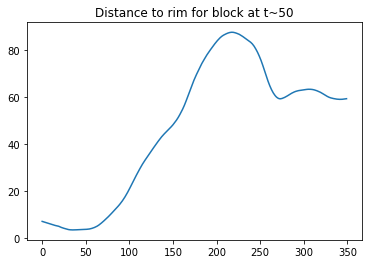

In [151]:
plt.plot(range(len(block_event)), block_event['dist_to_rim_2'])
plt.title('Distance to rim for block at t~50')

Text(0.5, 1.0, 'Acceleration/Velocity towards rim for block at ~t=50')

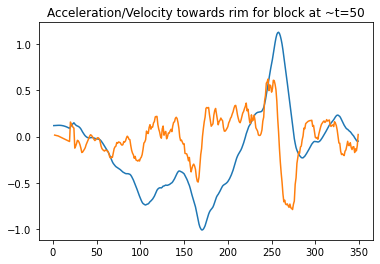

In [150]:
plt.plot(range(len(block_event)), block_event['avg_vel_rim_2'])
plt.plot(range(len(block_event)), block_event['avg_acc_rim_2']*10)
plt.title("Acceleration and Velocity towards rim for block at ~t=50")

In [109]:
event['moments'][0]

[4,
 1451773821012,
 10.07,
 None,
 None,
 [[-1, -1, 7.6618, 10.00846, 5.26211],
  [1610612738, 202323, 45.20728, 6.77465, 0.0],
  [1610612738, 202738, 50.55905, 34.90577, 0.0],
  [1610612738, 201973, 24.92639, 5.68136, 0.0],
  [1610612738, 203109, 12.28526, 23.52594, 0.0],
  [1610612738, 203935, 8.41817, 9.71417, 0.0],
  [1610612751, 2207, 51.87558, 4.16667, 0.0],
  [1610612751, 201961, 13.63041, 9.63181, 0.0],
  [1610612751, 201152, 28.77187, 4.44506, 0.0],
  [1610612751, 201572, 12.54839, 14.54614, 0.0],
  [1610612751, 203499, 58.78752, 30.55241, 0.0]]]

In [209]:
final_metrics.to_csv('final_metrics.csv', index=False)

In [210]:
len(final_metrics)

214